# Exploratory Data Analysis 

Let’s import the necessary libraries, and store the data in our system for analysis. Data is taken from:
http://archive.ics.uci.edu/ml/datasets/Online+Retail+II

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
data = pd.read_excel('online_retail_II.xlsx', sheet_name=None)

Let's have a look at the data. 

In [87]:
data

{'Year 2009-2010':        Invoice StockCode                          Description  Quantity  \
 0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
 1       489434    79323P                   PINK CHERRY LIGHTS        12   
 2       489434    79323W                  WHITE CHERRY LIGHTS        12   
 3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
 4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
 ...        ...       ...                                  ...       ...   
 525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
 525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
 525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
 525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
 525460  538171     21931               JUMBO STORAGE BAG SUKI         2   
 
                InvoiceDate  Price  Customer ID         Country  
 0

There are 2 sheets for different time period with 8 columns. We can simply combine the 2 data sheets.

In [88]:
df = pd.concat(data[frame] for frame in data.keys())
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [89]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


There are 1,067,371 rows (records). There are NULL values in the Customer ID and Country fields. We need to get rid of them.

In [90]:
df = df[df['Customer ID'].notnull()]
#df.isnull().sum().sort_values(ascending=False)

If there is any duplicated data that needs to be removed as well.

In [91]:
df.drop_duplicates();

Now we have a clean dataset. Let's start analysing. 

Some rows have the same Invoice number which means there are transactions for multiple items per customer. How many unique transactions do we have?

In [92]:
print(df.Invoice.nunique(), 'invoice')
print(df['Customer ID'].nunique(), 'customers')

44876 invoice
5942 customers


How many unique transactions per country? (Print only the head of the data frame) 

In [93]:
tr_per_country = df.groupby('Country')['Invoice'].nunique(dropna = True).sort_values(ascending=False)
tr_per_country.head()

Country
United Kingdom    40505
Germany            1095
France              738
EIRE                727
Netherlands         250
Name: Invoice, dtype: int64

Let's check how many customers each country have.

In [94]:
df.groupby('Country')['Customer ID'].nunique().sort_values(ascending=False).head()

Country
United Kingdom    5410
Germany            107
France              95
Spain               41
Belgium             29
Name: Customer ID, dtype: int64

So in UK, there are 5410 customers and from these customers there are 40,505 unique invoices.

Let's check how much money each customer spends? First we need to calculate the total amount of money spent on each sale by adding a new column (Total = Quantity * Price). 

In [95]:
df['Total'] = df.Quantity * df.Price


In [96]:
df[['Quantity', 'Price', 'Total']].describe()

,Quantity,Price,Total
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,20.195317
std,188.976099,70.241388,308.685001
min,-80995.000000,0.000000,-168469.600000
25%,2.000000,1.250000,4.250000
50%,5.000000,1.950000,11.250000
75%,12.000000,3.750000,19.500000
max,80995.000000,38970.000000,168469.600000


Above, in the statistics of data, we see customers on average purchase 12 items. We also see 'Quantity' and 'Total' columns have negative numbers. Negative quantity does not make sense. We should remove them. On average customers spend 20 UK pounds (assuming the unit is UK) while the maximum can be as high as 168,470 UK pounds.

In [97]:
df = df[df['Quantity'] > 0]

Let's calculate the fraction of transaction per country and visualize it for only 5 countries with most sales. 

United Kingdom    0.900295
Germany           0.020733
EIRE              0.019544
France            0.017146
Netherlands       0.006322
Name: Country, dtype: float64
%90 of sales are from United Kingdom.


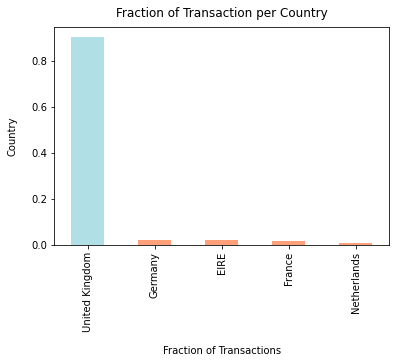

In [98]:
print(df.Country.value_counts(normalize=True).head())
df['Country'].value_counts(normalize=True)[:5].plot(kind='bar', color = ['powderblue','lightsalmon','lightsalmon','lightsalmon','lightsalmon'])
plt.xlabel("Fraction of Transactions", labelpad=14)
plt.ylabel("Country", labelpad=14)
plt.title("Fraction of Transaction per Country", y=1.02);
print('%90 of sales are from United Kingdom.')

What about the total revenue per country?

Country
United Kingdom    1.472315e+07
EIRE              6.216311e+05
Netherlands       5.542323e+05
Germany           4.312625e+05
France            3.552575e+05
Name: Total, dtype: float64
Total revenu:  17743429.178000007


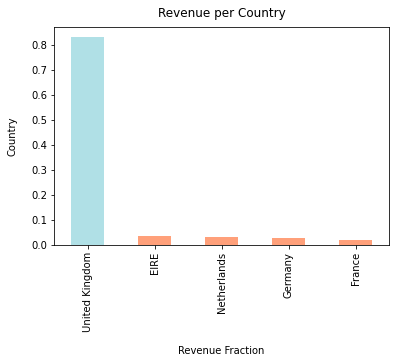

In [99]:
print(df.groupby(['Country'])['Total'].sum().sort_values(ascending=False)[:5])
print('Total revenu: ', df['Total'].sum())
(df.groupby(['Country'])['Total'].sum()/df['Total'].sum()).sort_values(ascending=False)[:5].plot(kind='bar', color = ['powderblue','lightsalmon','lightsalmon','lightsalmon','lightsalmon'])
plt.xlabel("Revenue Fraction", labelpad=14)
plt.ylabel("Country", labelpad=14)
plt.title("Revenue per Country", y=1.02);

%83 of the revenue is coming from UK. But which customers make the most sales and which ones spend more? Let's find out.

In [67]:
df['Customer ID'].value_counts()


17841.0    12890
14911.0    11247
12748.0     7230
14606.0     6566
14096.0     5111
           ...  
13215.0        1
13205.0        1
13185.0        1
18133.0        1
15313.0        1
Name: Customer ID, Length: 5881, dtype: int64

Within 5881 customers, the one with the Customer ID 17841 has the maximum number of transactions. Is it the one who spends most? Let's find out:


In [68]:
df.groupby(['Customer ID'])['Total'].sum().sort_values(ascending=False).reset_index()

,Customer ID,Total
0,18102.0,608821.65
1,14646.0,528602.52
2,14156.0,313946.37
3,14911.0,295972.63
4,17450.0,246973.09
...,...,...
5876,16738.0,3.75
5877,14095.0,2.95
5878,14827.0,0.00
5879,13256.0,0.00


Although ID 17841 made the most transactions, the customer ID 18102 spent the most. Let's check which customers spend the most and provides the most of the revenue for the company?  

     Customer ID     Total
0        18102.0  0.034313
1        14646.0  0.064104
2        14156.0  0.081798
3        14911.0  0.098478
4        17450.0  0.112397
..           ...       ...
253      15290.0  0.497418
254      16782.0  0.498006
255      14028.0  0.498592
256      15296.0  0.499175
257      14422.0  0.499754

[258 rows x 2 columns]
This means only 4 % customers provide the 50% revenue of the company.


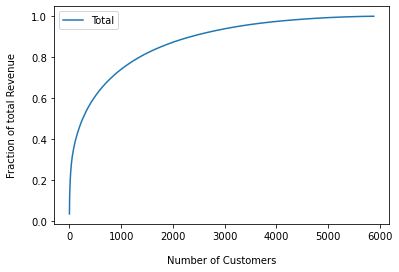

In [69]:
Revenue_per_customer_cumulative = (df.groupby(['Customer ID'])['Total'].sum().sort_values(ascending=False).cumsum()/df['Total'].sum()).reset_index()
Revenue_per_customer_cumulative.plot(y='Total')
plt.xlabel("Number of Customers", labelpad=14)
plt.ylabel("Fraction of total Revenue", labelpad=14)

print(Revenue_per_customer_cumulative[Revenue_per_customer_cumulative['Total']<0.5])
print('This means only',round(len(Revenue_per_customer_cumulative[Revenue_per_customer_cumulative['Total']<0.5])* 100 /df['Customer ID'].nunique()),'%','customers provide the 50% revenue of the company.')


A customer might seem like spending the most but maybe he/she made just a few orders with big amount. It does not mean that customer is a loyal customer. However, if they provide most of the revenue they are still the most important target customers. Now let's analze the customers based on the frequency of their transactions, and recency of their transctions. This is basically called RFM (Recency, Frequency, Monetary) analysis.

# RFM Analysis

What is the date range in our data set?

In [70]:
df['InvoiceDate'].min(),df['InvoiceDate'].max()


(Timestamp('2009-12-01 07:45:00'), Timestamp('2011-12-09 12:50:00'))

We need to create a recent date to calculate the recency of all dates in the data. For this let's add one day to the last day in the dataset.

In [71]:
recent_date = df['InvoiceDate'].max() + timedelta(days=1)
print(recent_date)

2011-12-10 12:50:00


Now, let's group the data by Customer_ID and create new columns for the recency, frequency and monetary variables.

In [72]:
#print(data_rfm.head())
data_rfm = df.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda date: (recent_date - date.max()).days,
        'Invoice': lambda num: len(num),
        'Total': lambda price: price.sum()})

Rename the columns:

In [73]:
data_rfm.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'Total': 'Monetary'}, inplace=True)

In [74]:
print(data_rfm.head())

             Recency  Frequency  Monetary
Customer ID                              
12346.0          326         34  77556.46
12347.0            2        253   5633.32
12348.0           75         51   2019.40
12349.0           19        175   4428.69
12350.0          310         17    334.40


Now we have a dataset for each Customer with their recency, frequency and monetary values.

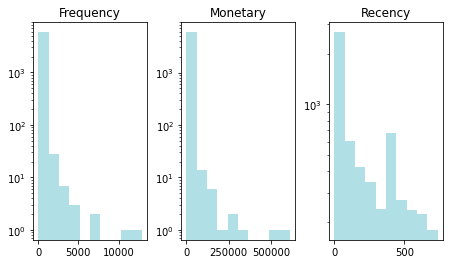

In [75]:
data_rfm.hist(color='powderblue', range=(None),figsize=(10,4), log= True, layout=(1,4), grid=False);

The customers with the smallest recency, and highest frequency and monetary are the top customers. Let's find them.

Now we will create groups based on their quantile membership by using qcut() function.

In [76]:
# Create labels
#r_labels = ['1','2','3','4']; f_labels = ['4','3','2','1']; m_labels = ['4','3','2','1']
r_labels = [5,4,3,2,1]; f_labels = [1,2,3,4,5]; m_labels = [1,2,3,4,5]
# Create 4 equal percentile groups 
r_groups = pd.qcut(data_rfm['Recency'], q=5, labels=r_labels)
f_groups = pd.qcut(data_rfm['Frequency'], q=5, labels=f_labels)
m_groups = pd.qcut(data_rfm['Monetary'], q=5, labels= m_labels)
# Create new columns 
data_rfm = data_rfm.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)
# Combine in a sinle column: 
data_rfm['RFM'] = data_rfm.R.astype(str)+ data_rfm.F.astype(str) + data_rfm.M.astype(str)
data_rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM
Customer ID,,,,,,,
12346.0,326,34,77556.46,2,2,5,225
12347.0,2,253,5633.32,5,5,5,555
12348.0,75,51,2019.40,3,3,4,334
12349.0,19,175,4428.69,5,4,5,545
12350.0,310,17,334.40,2,2,2,222


We can check the top 10 best customers by low recency, high frequency and monetary and sort the first 10 by their monetary value.

In [78]:
data_rfm[data_rfm['RFM']=='555'].sort_values('Monetary', ascending=False).head(10)


,Recency,Frequency,Monetary,R,F,M,RFM
Customer ID,,,,,,,
18102.0,1,1058,608821.65,5,5,5,555
14646.0,2,3854,528602.52,5,5,5,555
14156.0,10,4048,313946.37,5,5,5,555
14911.0,1,11247,295972.63,5,5,5,555
17450.0,8,425,246973.09,5,5,5,555
13694.0,4,1525,196482.81,5,5,5,555
17511.0,3,1911,175603.55,5,5,5,555
16684.0,4,718,147142.77,5,5,5,555
15061.0,4,987,137818.52,5,5,5,555


Let's group the customers into 11 segments based on the R, F, M values following the info given in this web page: 
https://www.putler.com/rfm-analysis/#:~:text=Applying%20RFM%20score%20formula,is%20the%20lowest%2Fworst%20value.

In [79]:
def rfm_class(df):
    if ((df['R'] >= 4) and (df['R'] <= 5) and (df['F'] >= 4) and (df['F'] <= 5) and (df['M'] >= 4) and (df['M'] <= 5)):
        return 'Champions'
    elif ((df['R'] >= 2) and (df['R'] <= 5) and (df['F'] >= 3) and (df['F'] <= 5) and (df['M'] >= 3) and (df['M'] <= 5)):
        return 'Loyal'
    elif ((df['R'] >= 3) and (df['R'] <= 5) and (df['F'] >= 1) and (df['F'] <= 3) and (df['M'] >= 1) and (df['M'] <= 3)):
        return 'Potential Loyalist'
    elif ((df['R'] >= 4) and (df['R'] <= 5) and (df['F'] >= 1) and (df['M'] >= 1)):
        return 'Recent'
    elif ((df['R'] >= 3) and (df['R'] <= 4) and (df['F'] >= 1) and (df['M'] >= 1)):
        return 'Promising'
    elif ((df['R'] >= 2) and (df['R'] <= 3) and (df['F'] >= 2) and (df['F'] <= 3) and (df['M'] >= 2) and (df['M'] <= 3)):
        return 'Need Attention'
    elif ((df['R'] >= 2) and (df['R'] <= 3) and (df['F'] >= 1) and (df['F'] <= 2) and (df['M'] > 0) and (df['M'] <= 2)):
        return 'About to Sleep'
    elif ((df['R'] > 0) and (df['R'] <= 2) and (df['F'] >= 2) and (df['F'] <= 5) and (df['M'] >= 2) and (df['M'] <= 5)): 
        return 'At Risk'
    elif ((df['R'] <= 1) and (df['F'] >= 4) and (df['F'] <= 5) and (df['M'] >= 4) and (df['M'] <= 5)): 
        return 'Cant Loose'
    elif ((df['R'] >= 1) and (df['R'] <= 2) and (df['F'] >= 1) and (df['F'] <= 2) and (df['M'] >= 1) and (df['M'] <= 2)):
        return 'Sleeping'
    elif ((df['R'] >= 1) and (df['R'] <= 2) and (df['F'] >= 1) and (df['F'] <= 2) and (df['M'] >= 1) and (df['M'] <= 2)):
        return 'Lost'
    
                                

In [80]:
data_rfm['RFM Class'] = data_rfm.apply(rfm_class, axis=1)


Let's see how many customers we have in each segment:

In [81]:
data_rfm.groupby(['RFM Class'])['RFM Class'].describe()

,count,unique,top,freq
RFM Class,,,,
About to Sleep,342,1,About to Sleep,342
At Risk,585,1,At Risk,585
Champions,1273,1,Champions,1273
Loyal,1585,1,Loyal,1585
Need Attention,296,1,Need Attention,296
Potential Loyalist,938,1,Potential Loyalist,938
Promising,67,1,Promising,67
Recent,101,1,Recent,101
Sleeping,553,1,Sleeping,553


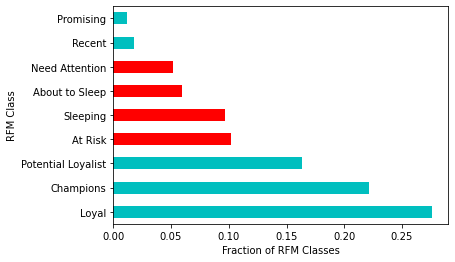

In [151]:
ax = data_rfm['RFM Class'].value_counts(normalize=True).plot(kind='barh', color=['c','c','c','r','r','r','r','c','c']);
ax.set_alpha(0.5)
ax.set_xlabel("Fraction of RFM Classes", fontsize=10);
ax.set_ylabel("RFM Class", fontsize=10);

This shows us that 65% of the customers are Loyal, Champions, Potential Loyalist. Let's also classify our customers by using a supervised machine learning method and find the ones churned or at high risk of churning.  

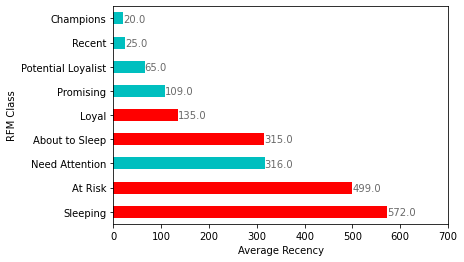

In [153]:
ax_2=data_rfm.groupby(['RFM Class'])['Recency'].mean().sort_values(ascending=False).plot(kind='barh', color=['r','r','c','r','r','c','c','c','c']);
ax_2.set_alpha(0.8)
ax_2.set_xlabel("Average Recency", fontsize=10);
ax_2.set_ylabel("RFM Class", fontsize=10);
ax_2.set_xticks([0, 100, 200, 300, 400, 500, 600, 700])

# set individual bar lables using above list
for i in ax_2.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax_2.text(i.get_width()+.1, i.get_y()+.11, \
            str(round((i.get_width()), 0)), fontsize=10, color='dimgrey')

This plot shows that the recency of our best customers ('Champions') is on average 20 days. And when a customer on average buys something 2 months ago, that customer can be a 'potential loyalist'.

# Customer Churning Prediction

We first create a subset of the data used in the RFM analysis, which contains only the first 18 months and then will use the last 6 months to find the customers that actually churned. At the same time, we will add one more column to the dataset that designates the number of days between the first and the last purchase of a customer, which we name 'Loyalty'.

In [244]:
df_f18m = df[df.InvoiceDate < '2011-06-09'].copy()

recent_date = df_f18m['InvoiceDate'].max() + timedelta(days=1)

df_f18m['Loyalty'] =df_f18m['InvoiceDate']
cl_data_f18m = df_f18m.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda date: (recent_date - date.max()).days,
        'Loyalty': lambda date: (recent_date - date.min()).days,
        'Invoice': lambda num: len(num),
        'Total': lambda price: price.sum()})
cl_data_f18m.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'Total': 'Monetary'}, inplace=True)
cl_data_f18m['Churned']=''

Bellow we make a copy of the full 24 month dataset, where we create a column with the label of whether a customer churned or not, using the full dataset. We will assume here that customers that did not buy something int he last 180 days, churned.

In [245]:
df_24m = df.copy()

recent_date = df_24m['InvoiceDate'].max() + timedelta(days=1)
df_24m['Loyalty'] =df_24m['InvoiceDate']
cl_data_24m = df_24m.groupby(['Customer ID']).agg({
        'InvoiceDate': lambda date: (recent_date - date.max()).days,
        'Loyalty': lambda date: (recent_date - date.min()).days,
        'Invoice': lambda num: len(num),
        'Total': lambda price: price.sum()})
cl_data_24m.rename(columns={'InvoiceDate': 'Recency',
                         'Invoice': 'Frequency',
                         'Total': 'Monetary'}, inplace=True)

def churned(df):
    if ((df['Recency'] >= 180)):
        return 'Yes'
    else:
        return 'No'
    
    
cl_data_24m['Churned'] = cl_data_24m.apply(churned, axis=1)

In [246]:
for idx in cl_data_f18m.index:
    cl_data_f18m.loc[idx,'Churned']  = cl_data_24m.loc[idx,'Churned']

Let's see now, from the customers that we had in the first 18 months, how many churned?

No     2566
Yes    2402
Name: Churned, dtype: int64

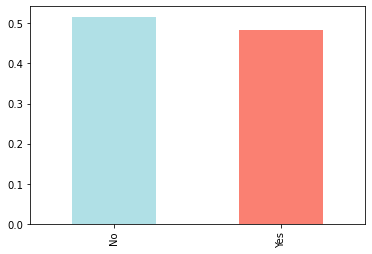

In [247]:
cl_data_f18m['Churned'].value_counts(normalize=True).plot(kind='bar', color=['powderblue', 'salmon']);
cl_data_f18m['Churned'].value_counts()
    

About 45% of the customers (2402 customers) of the first 18 months churned. 

In the following, with a classification model we will find customers who are likely to churn. FOr that, we would like to add one more feature that shows the diversity in their purchase history. That can be represented by the number of unique items that they have bought.

In [248]:
cl_data_f18m['UniqueItems'] = df_f18m.groupby('Customer ID')['StockCode'].nunique()
cl_data_24m['UniqueItems'] = df_24m.groupby('Customer ID')['StockCode'].nunique()

For our classification analysis, we use the following variables as features: Recency, Loyalty, Frequency, Monetary, and UniqueItems. We need to convert these features to numerical data and rescale them.

In [249]:
#non-numeric columns to numerical data types
for column in cl_data_f18m.columns:
   if cl_data_f18m[column].dtype == np.number:
      continue
   cl_data_f18m[column] = LabelEncoder().fit_transform(cl_data_f18m[column])

#Let's scale the cleaned data:
X = cl_data_f18m.drop(columns=['Churned'])#, axis = 1) 
y = cl_data_f18m['Churned']
X = StandardScaler().fit_transform(X)

In [250]:
#Split the data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now let's create and train our model.

In [251]:
#Create the model
model = LogisticRegression()
#model = RandomForestClassifier(max_depth=2, random_state=0)
#Train the model
model.fit(x_train, y_train);

/Users/gozde/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Evaluation of the model:

In [252]:
predictions = model.predict(x_test)
print( classification_report(y_test, predictions) )

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       501
           1       0.72      0.75      0.74       493

    accuracy                           0.73       994
   macro avg       0.73      0.73      0.73       994
weighted avg       0.73      0.73      0.73       994



Recall, precission and f1-score of the model are about 75%. This means that the model correctly identified 3 out of 4 churning customers. This is not bad for a simple classification model. This can be improved by using more sofisticated algorithms and experimenting with different combinations of features in our model.  

Now it is time to apply our classifier model in our full dataset. Customers that have not yet churned but are classified as "churned" by the classifier are customers with a high risk (~75% based on the accuracy of our model) of churning.

In [253]:
X = cl_data_24m.drop(columns=['Churned'])#, axis = 1) 
X = StandardScaler().fit_transform(X)
cl_data_24m['Predicted'] = model.predict(X)

In [259]:
cl_data_24m

,Recency,Loyalty,Frequency,Monetary,Churned,UniqueItems,Predicted
Customer ID,,,,,,,
12346.0,326,726,34,77556.46,Yes,27,0
12347.0,2,404,253,5633.32,No,126,0
12348.0,75,438,51,2019.40,No,25,0
12349.0,19,589,175,4428.69,No,138,0
12350.0,310,310,17,334.40,Yes,17,1
...,...,...,...,...,...,...,...
18283.0,4,658,986,2736.65,No,352,0
18284.0,432,432,28,461.68,Yes,28,1
18285.0,661,661,12,427.00,Yes,12,1


Print the customers at high risk of churning:

In [258]:
high_risk_customers = cl_data_24m[(cl_data_24m['Predicted'] ==1) & (cl_data_24m['Churned'] =='No')]
high_risk_customers

,Recency,Loyalty,Frequency,Monetary,Churned,UniqueItems,Predicted
Customer ID,,,,,,,
12405.0,149,149,54,1710.39,No,54,1
12453.0,134,134,43,707.09,No,43,1
12493.0,166,197,22,433.74,No,20,1
12521.0,143,143,38,599.68,No,38,1
12534.0,131,131,63,1089.18,No,63,1
...,...,...,...,...,...,...,...
18024.0,153,153,21,389.78,No,21,1
18099.0,127,127,19,168.31,No,19,1
18121.0,149,155,32,673.10,No,28,1


Based on our model, with the acuracy of 75%, 102 customers are at high risk of churning at the second half of 2011. 